# L1 filtering schemes

## Application to trend-stationary process

### Model 1 with HP Filter

In [181]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
from scipy.optimize import minimize
import cvxpy as cp
from scipy.sparse import diags
from scipy.sparse import spdiags
import yfinance as yf

In [182]:
# Génération des données du Modèle 1
def generate_model1_data(n, sigma, p, b):
    """
    Génère des données selon le modèle 1 avec des tendances perturbées.
    """
    #np.random.seed(42)
    x_t = np.zeros(n)
    v_t = np.random.uniform(-b / 2, b / 2)
    for t in range(1, n):
        if np.random.rand() < p:
            x_t[t] = x_t[t - 1] + v_t
        else:
            v_t = np.random.uniform(-b / 2, b / 2)
            x_t[t] = x_t[t - 1] + v_t
    noise = np.random.normal(0, sigma, n)
    y_t = x_t + noise
    return x_t, y_t

# Génération des données du Modèle 2
def generate_model2_data(n, sigma, p, b):
    """
    Génère des données selon le modèle 2 avec une marche aléatoire perturbée.
    """
    #np.random.seed(42)
    y_t = np.zeros(n)
    v_t = np.random.uniform(-b / 2, b / 2)
    for t in range(1, n):
        if np.random.rand() < p:
            v_t = v_t
        else:
            v_t = np.random.uniform(-b / 2, b / 2)
        y_t[t] = y_t[t - 1] + v_t + np.random.normal(0, sigma)
    return y_t

In [183]:
# Appliquer le filtre HP
def apply_HP_filter(y, lambda_val):
    """
    Applique le filtre Hodrick-Prescott (HP) à une série temporelle y.
    """
    n = len(y)
    D = diags([1, -2, 1], [0, 1, 2], shape=(n - 2, n))  # Opérateur D
    DTD = D.T @ D  # D^T * D
    I = diags([1], [0], shape=(n, n))  # Matrice identité
    # Résolution de l'équation linéaire pour obtenir x_t
    A = I + lambda_val * DTD
    x = spsolve(A, y)
    return x

def apply_HP_filter_cvxpy(y, lambda_val):
    """
    Applique le filtre Hodrick-Prescott (HP) avec CVXPY pour une valeur donnée de lambda.
    """
    n = len(y)
    # Construction de la matrice D pour la régularisation
    D = spdiags([np.ones(n), -2 * np.ones(n), np.ones(n)], [0, 1, 2], n - 2, n).toarray()
    # Définition de la variable d'optimisation
    x = cp.Variable(n)
    # Fonction objectif
    objective = cp.Minimize(0.5 * cp.sum_squares(y - x) + lambda_val * cp.norm(D @ x, p=2))
    # Problème d'optimisation
    problem = cp.Problem(objective)
    problem.solve(solver=cp.SCS)
    return np.array(x.value), problem.value

# Fonction pour générer la matrice de différences
def getD(n, diff_order=2):
    D = spdiags([np.ones(n), -2 * np.ones(n), np.ones(n)], [0, 1, 2], n - 2, n).toarray()
    for _ in range(diff_order - 2):
        D = np.diff(D, axis=0)
    return D
    
# Fonction d'optimisation du filtre L1
def optimize_l1_filter(y, D, lambda_val):
    """
    Optimise le filtre L1 pour une valeur donnée de lambda.
    """
    n = len(y)
    reg_norm = 1  # Norme L1
    # Définition de la variable d'optimisation
    x = cp.Variable(n)
    # Fonction objectif
    objective = cp.Minimize(0.5 * cp.sum_squares(y - x) + lambda_val * cp.norm(D @ x, p=reg_norm))
    # Problème d'optimisation
    problem = cp.Problem(objective)
    problem.solve(solver=cp.SCS, max_iters=10000)
    if problem.status != cp.OPTIMAL:
        print("Problème non convergent pour lambda =", lambda_val)
    # Retourner le signal optimisé
    return np.array(x.value)


# Procedure CV_Filter
def CV_Filter(x_hist, T1=100, T2=20, m=5, n_lambda=20):
    x_hist = np.asarray(x_hist).flatten()
    len_x = len(x_hist)
    len_cv = m * T2
    cv_indices = np.arange(len_x - len_cv, len_x)
    cv_splits = np.array_split(cv_indices, m)

    # Étape 1 : Calcul de λ_max pour chaque fenêtre de test T2
    lambda_max_list = []
    for indices in cv_splits:
        T2_data = x_hist[indices]
        lambda_max = np.max(np.abs(np.diff(T2_data)))  # Approximation pour λ_max
        lambda_max_list.append(lambda_max)

    lambda_mean = np.mean(lambda_max_list)
    lambda_std = np.std(lambda_max_list)
    lambda1 = lambda_mean - 2 * lambda_std
    lambda2 = lambda_mean + 2 * lambda_std

    # Étape 2 : Génération des valeurs de λ entre λ1 et λ2
    lambdas = [lambda1 * (lambda2 / lambda1) ** (j / n_lambda) for j in range(n_lambda)]

    # Étape 3 : Validation croisée avec les fenêtres d'entraînement et de test
    D = getD(T1, diff_order=2)
    errors = []

    for lam in lambdas:
        total_error = 0
        for indices in cv_splits:
            train_start = indices[0] - T1
            train_indices = np.arange(train_start, indices[0])
            test_indices = indices

            # Fenêtre d'entraînement et de test
            train_data = x_hist[train_indices]
            test_data = x_hist[test_indices]

            # Application du filtre L1
            trend = optimize_l1_filter(train_data, D, lam)
            if trend is None:
                continue

            # Prédiction sur la fenêtre test
            trend_forecast = trend[-T2:]
            error = np.mean((trend_forecast - test_data) ** 2)
            total_error += error

        errors.append(total_error)

    # Étape 4 : Trouver le lambda optimal
    best_lambda = lambdas[np.argmin(errors)]

    # Étape 5 : Application finale du filtre L1
    final_trend = optimize_l1_filter(x_hist[-T1:], D, best_lambda)

    # Résultats
    result = {
        'best_lambda': best_lambda,
        'errors': errors,
        'train_trend': final_trend
    }
    return result


In [184]:
# Paramètres du modèle
n = 2000  # Nombre d'observations
sigma = 15  # Écart-type du bruit
p = 0.99  # Probabilité de continuité de la tendance
b = 0.5  # Amplitude des ruptures
lambda_HP = 1217464  # Paramètre de régularisation pour le filtre HP

### Model 2 with HP Filter

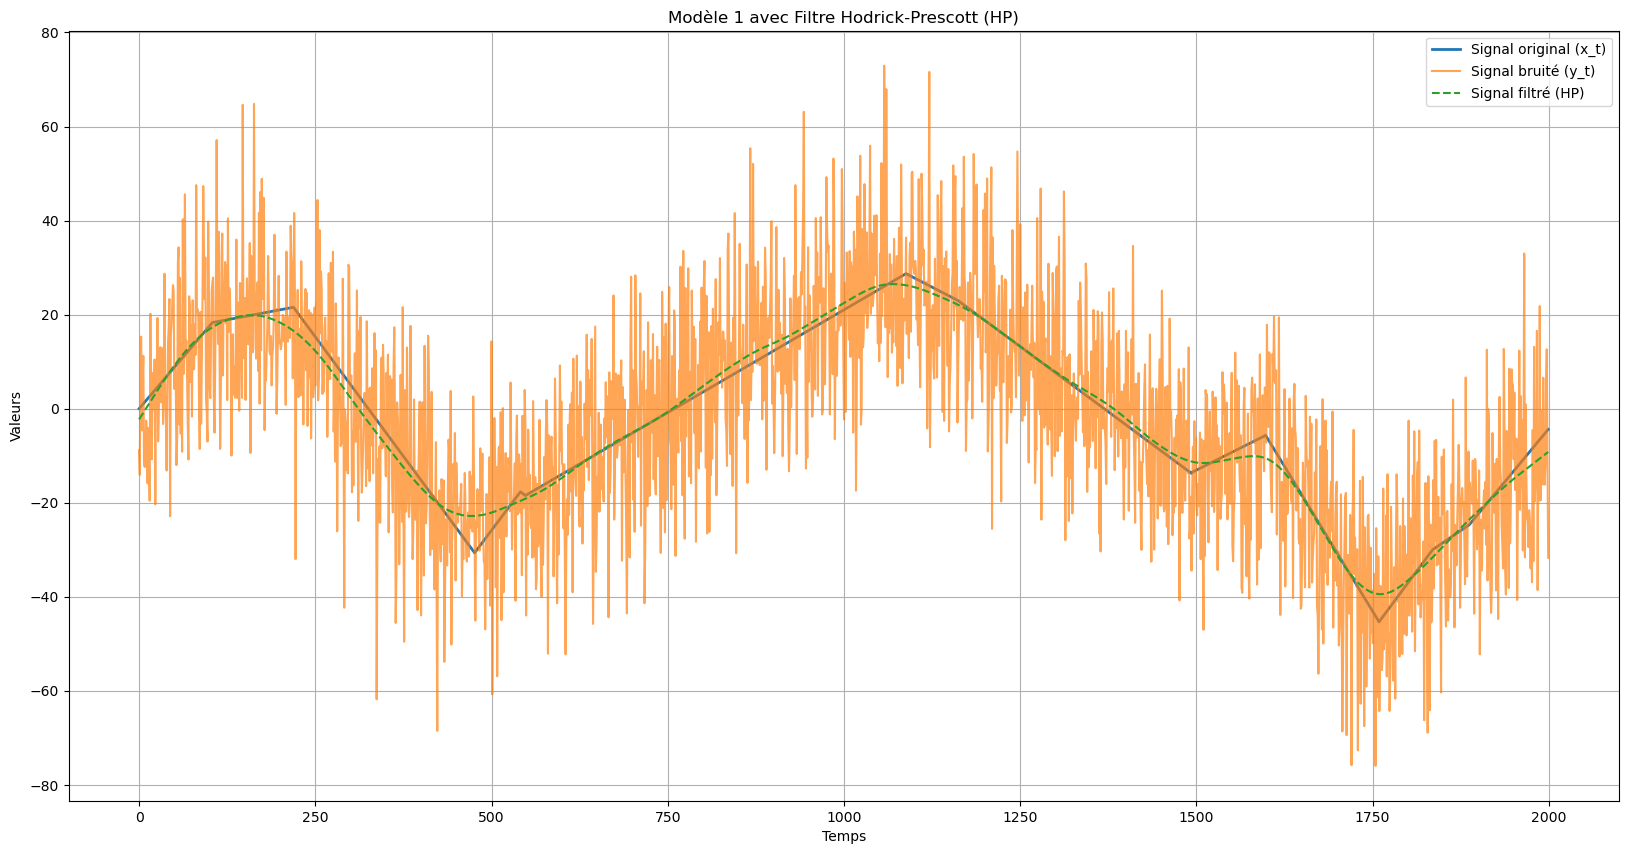

In [185]:
# Générer les données
x_t, y_t = generate_model1_data(n=n, sigma=sigma, p=p, b=b)

# Appliquer le filtre HP
x_HP = apply_HP_filter(y_t, lambda_HP)

# Visualisation des résultats
plt.figure(figsize=(20, 10))
plt.plot(x_t, label="Signal original (x_t)", linewidth=2)
plt.plot(y_t, label="Signal bruité (y_t)", alpha=0.7)
plt.plot(x_HP, label="Signal filtré (HP)", linestyle="--")
plt.legend()
plt.title("Modèle 1 avec Filtre Hodrick-Prescott (HP)")
plt.xlabel("Temps")
plt.ylabel("Valeurs")
plt.grid()
plt.show()

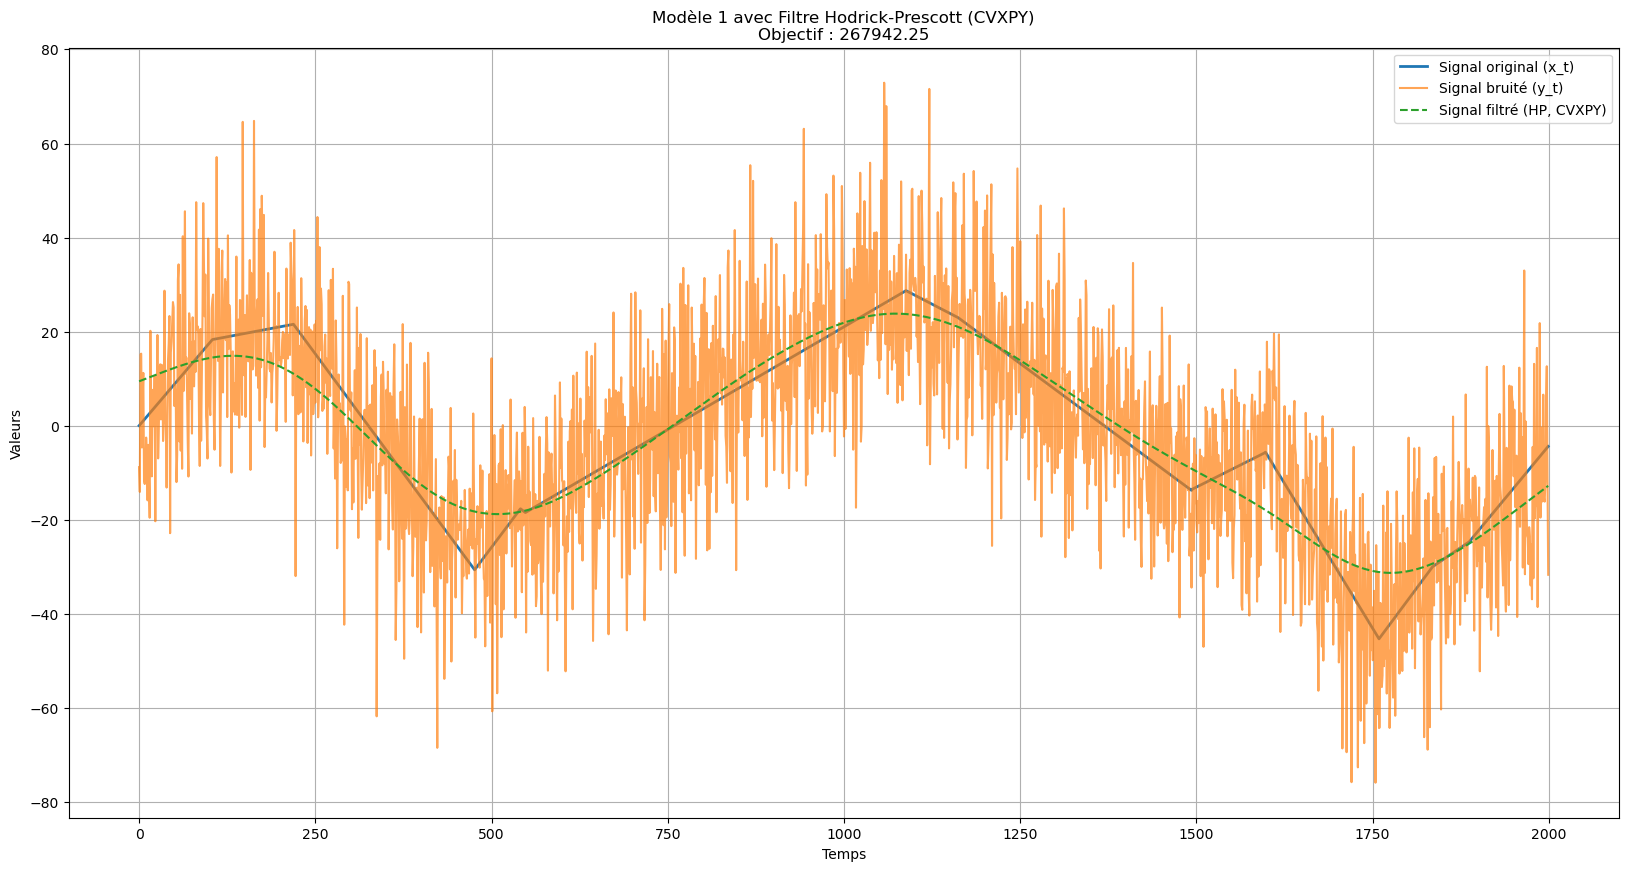

In [186]:
# Appliquer le filtre HP avec CVXPY
x_HP_cvxpy, objective_value = apply_HP_filter_cvxpy(y_t, lambda_HP)

# Visualisation des résultats
plt.figure(figsize=(20, 10))
plt.plot(x_t, label="Signal original (x_t)", linewidth=2)
plt.plot(y_t, label="Signal bruité (y_t)", alpha=0.7)
plt.plot(x_HP_cvxpy, label="Signal filtré (HP, CVXPY)", linestyle="--")
plt.legend()
plt.title(f"Modèle 1 avec Filtre Hodrick-Prescott (CVXPY)\nObjectif : {objective_value:.2f}")
plt.xlabel("Temps")
plt.ylabel("Valeurs")
plt.grid()
plt.show()

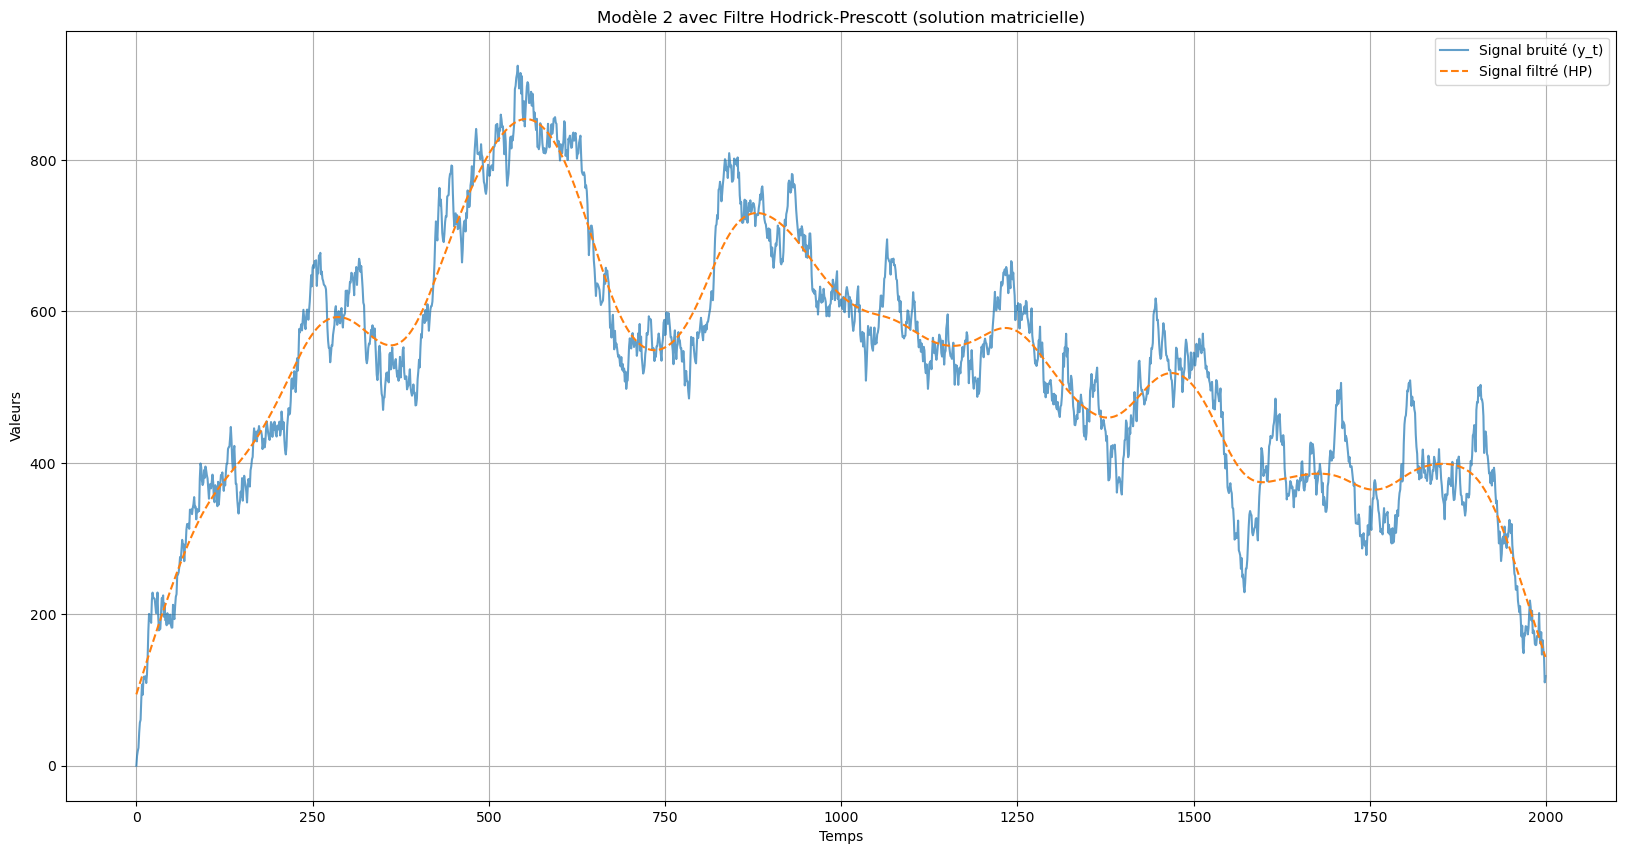

In [187]:
# Générer les données
y_t = generate_model2_data(n=n, sigma=sigma, p=p, b=b)

# Appliquer le filtre HP
x_HP = apply_HP_filter(y_t, lambda_HP)

# Visualisation des résultats
plt.figure(figsize=(20, 10))
plt.plot(y_t, label="Signal bruité (y_t)", alpha=0.7)
plt.plot(x_HP, label="Signal filtré (HP)", linestyle="--")
plt.legend()
plt.title("Modèle 2 avec Filtre Hodrick-Prescott (solution matricielle)")
plt.xlabel("Temps")
plt.ylabel("Valeurs")
plt.grid()
plt.show()

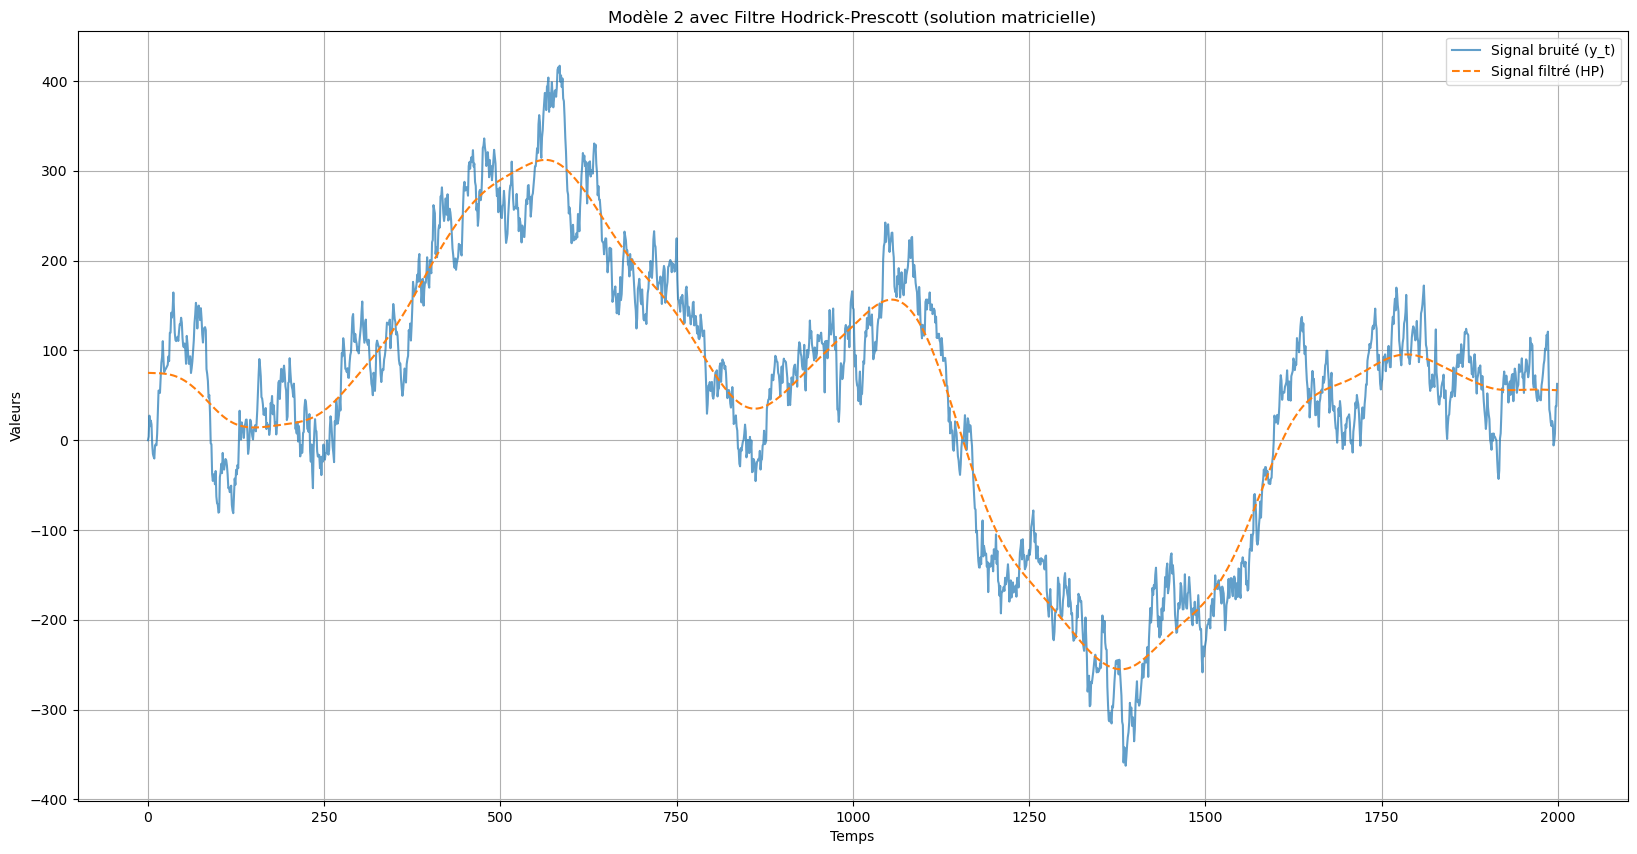

In [188]:
# Générer les données
y_t_model2 = generate_model2_data(n=n, sigma=sigma, p=p, b=b)

# Appliquer le filtre HP
x_filtered, objective_value = apply_HP_filter_cvxpy(y_t_model2, lambda_HP)

# Visualisation des résultats
plt.figure(figsize=(20, 10))
plt.plot(y_t_model2, label="Signal bruité (y_t)", alpha=0.7)
plt.plot(x_filtered, label="Signal filtré (HP)", linestyle="--")
plt.legend()
plt.title("Modèle 2 avec Filtre Hodrick-Prescott (solution matricielle)")
plt.xlabel("Temps")
plt.ylabel("Valeurs")
plt.grid()
plt.show()

### L1 filter

In [212]:
# Paramètres d'exécution
n = 2000
sigma = 15
p = 0.99
b = 0.5
T1 = 100
T2 = 20
m = 5
n_lambda = 10

In [213]:
# Exécution de l'algorithme
x_t_model1, y_t_model1 = generate_model1_data(n, sigma, p, b)
result = CV_Filter(y_t_model1, T1=T1, T2=T2, m=m, n_lambda=n_lambda)

# Affichage des résultats
print("Lambda optimal :", result['best_lambda'])
print("Erreurs :", result['errors'])

Lambda optimal : 70.12341332407829
Erreurs : [1337.1547838727029, 1329.981053043065, 1323.7963602622426, 1318.0522383780008, 1312.7864073578462, 1308.5076362120362, 1304.782253369471, 1302.08089713653, 1299.230694734907, 1296.2634623935592]


In [216]:
# Construire la matrice D pour le filtre L1
D = spdiags([np.ones(n), -2 * np.ones(n), np.ones(n)], [0, 1, 2], n - 2, n).toarray()
lambda_val = 4000

#### Model 1

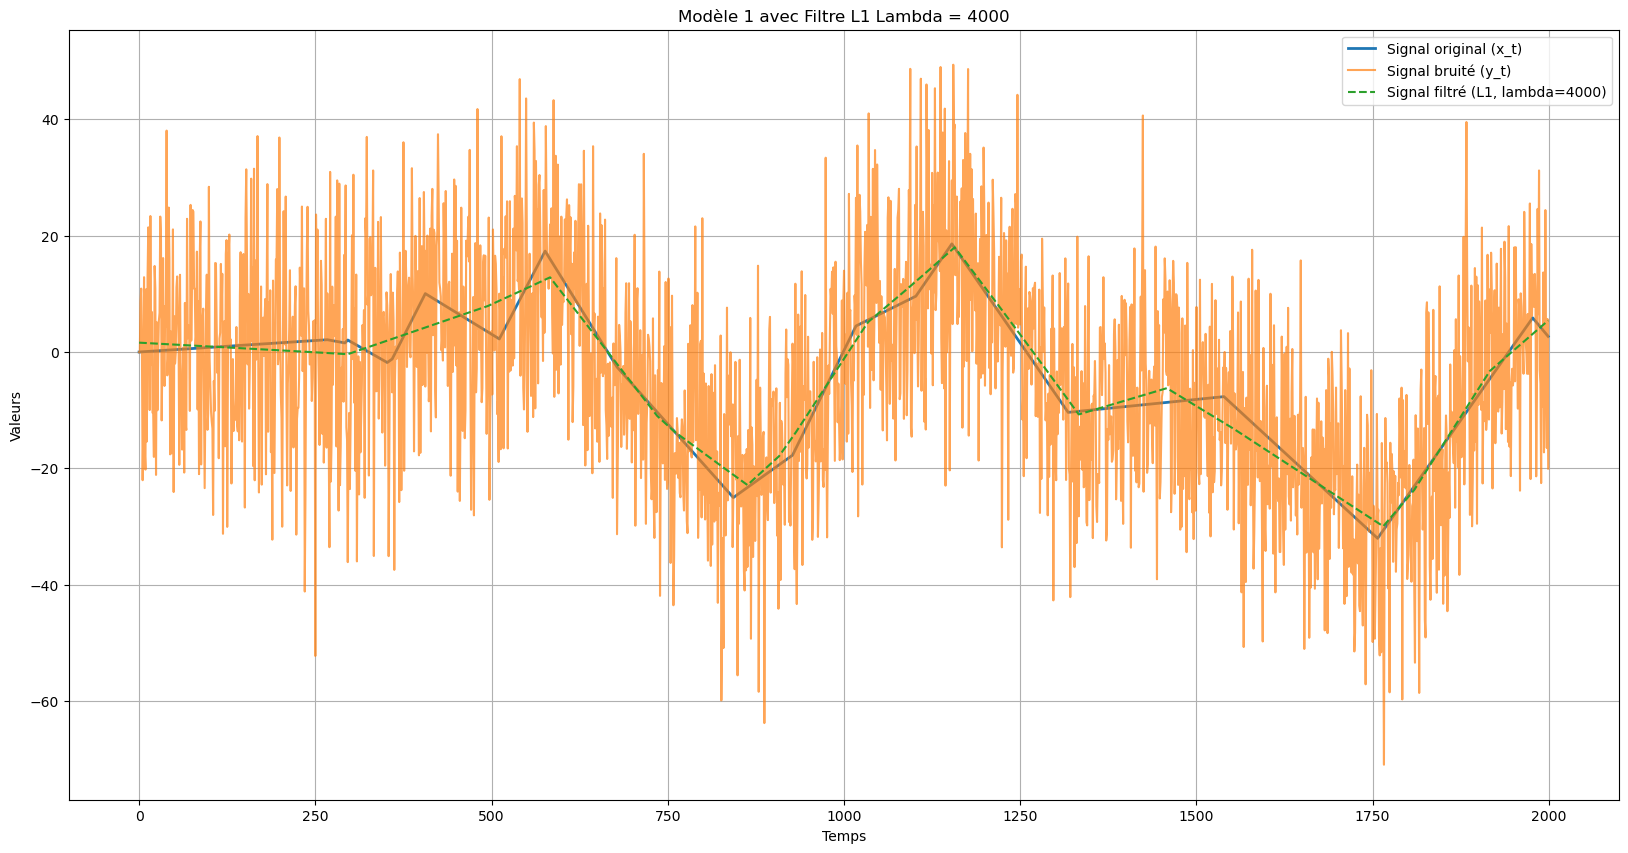

In [217]:
#Générer les données
x_t_model1, y_t_model1 = generate_model1_data(n=n, sigma=sigma, p=p, b=b)

# Appliquer l'optimisation pour une valeur de lambda
x_filtered = optimize_l1_filter(y_t_model1, D, lambda_val)

# Graphique des résultats
plt.figure(figsize=(20, 10))
plt.plot(x_t_model1, label="Signal original (x_t)", linewidth=2)
plt.plot(y_t_model1, label="Signal bruité (y_t)", alpha=0.7)
plt.plot(x_filtered, label=f"Signal filtré (L1, lambda={lambda_val})", linestyle="--")
plt.legend()
plt.title(f"Modèle 1 avec Filtre L1 Lambda = {lambda_val}")
plt.xlabel("Temps")
plt.ylabel("Valeurs")
plt.grid()
plt.show()

#### Model 2

In [218]:
len(y_t_model2)

2000

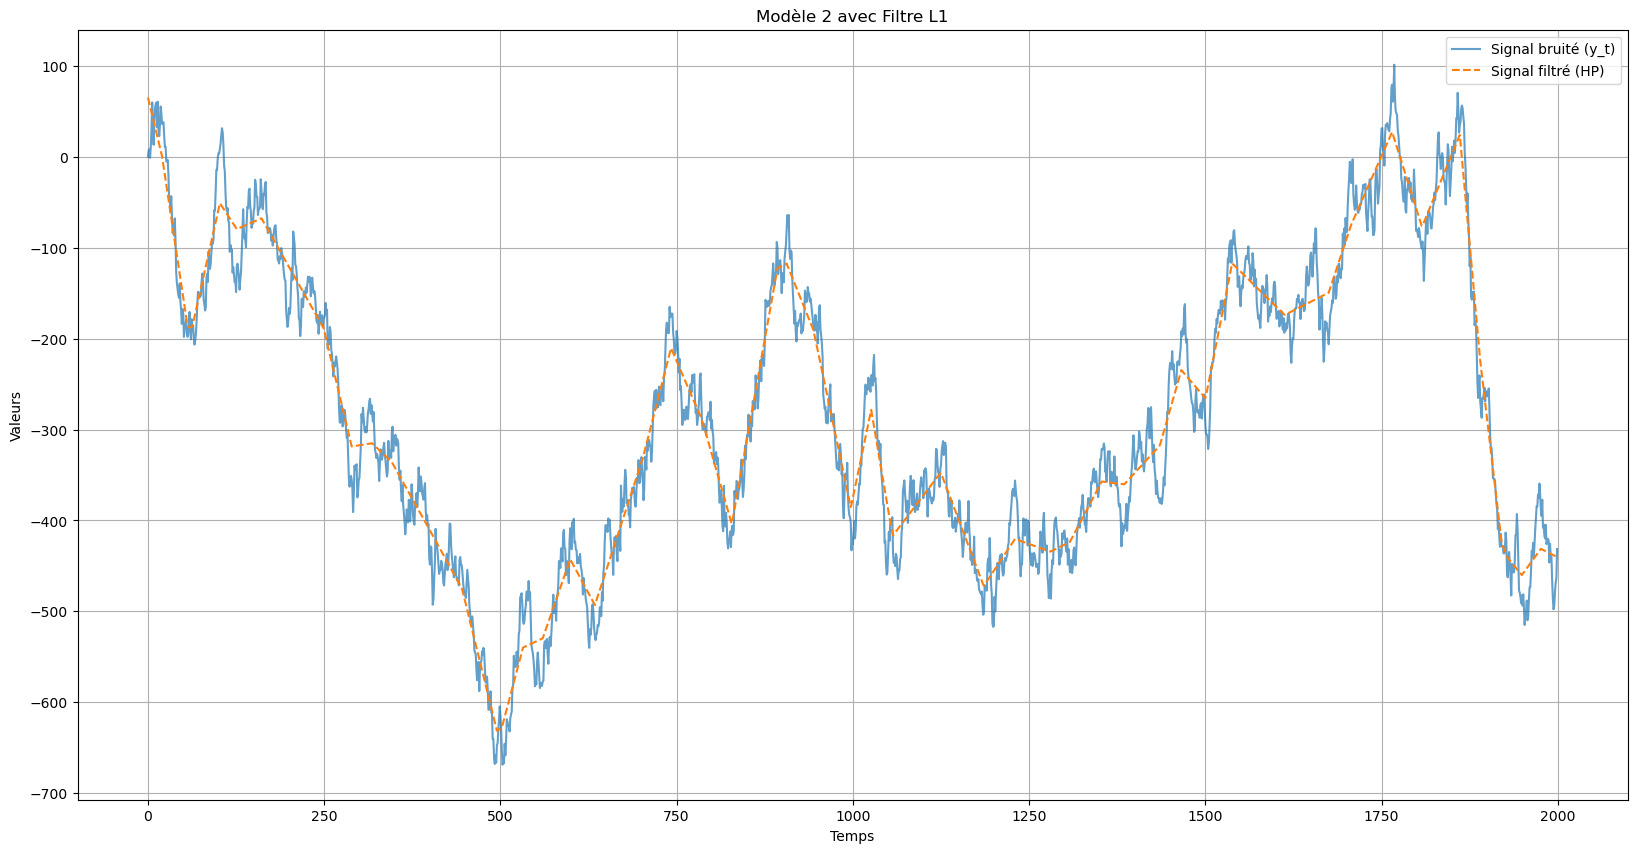

In [219]:
# Générer les données
y_t_model2 = generate_model2_data(n=n, sigma=sigma, p=p, b=b)

# Appliquer l'optimisation pour une valeur de lambda
x_filtered = optimize_l1_filter(y_t_model2, D, lambda_val)

# Visualisation des résultats
plt.figure(figsize=(20, 10))
plt.plot(y_t_model2, label="Signal bruité (y_t)", alpha=0.7)
plt.plot(x_filtered, label="Signal filtré (HP)", linestyle="--")
plt.legend()
plt.title("Modèle 2 avec Filtre L1")
plt.xlabel("Temps")
plt.ylabel("Valeurs")
plt.grid()
plt.show()